 In this notebook, we will train a classifier on the synthetic presence-absence datasets and use it to produce RISE CAMs. For more details, please see [the paper](https://arxiv.org/abs/1806.07421).

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Iterable
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras import backend as K
from typing import Optional, List, Tuple, Any
import tensorflow_addons as tfa

In [ ]:
opj = os.path.join
resnet = tf.keras.applications.resnet

In [ ]:
DATA_NAME = "cityscapes2foggy-new"
# DATA_NAME = "foggy2cityscapes-new"

In [ ]:
data_path = "/path/to/data/%s" % DATA_NAME

In [ ]:
def read_dataset(data_path: str) -> tf.data.Dataset:
  raise NotImplementedError()

def write_data(dataset: tf.data.Dataset, fpath: str):
  raise NotImplementedError()

# Predict RISE CAMS on the new data

## Create a classification dataset with "present" and "absent" classes.
We will load a classification dataset from an SSTable and use it to train a ResNet classifier to predict whether an object is present on a given image.

In [ ]:
def pixel_aug(
    img, 
    intensity: int, 
    image_size: Tuple[int, int]) -> tf.Tensor:
  """Pixel-level augmentations."""
  img = tf.image.random_brightness(img, max_delta=0.005 * intensity)
  img = tf.image.random_contrast(
      img, 1. - 0.05 * intensity, 1. + 0.05 * intensity)
  img = tf.image.random_hue(img, 0.1 * intensity)
  img = tf.image.random_saturation(
      img, 1. - 0.1 * intensity, 1 + 0.2 * intensity)
  img = img + tf.random.normal((*image_size, 3), 0., 5. * intensity)
  img = tf.clip_by_value(img, 0., 255.)
  return img


def get_rand_masks(
    num_masks: int, 
    image_size: Tuple[int, int]) -> tf.Tensor:
  grid_size = (np.array(image_size) / 32).astype(np.int32)
  grid_size = (num_masks, *grid_size, 1)
  rand_grid = tf.random.uniform(grid_size, 0., 1., tf.float32)
  rand_grid = tf.cast(rand_grid < 0.4, tf.float32)
  out_masks = []
  for idx in range(num_masks):
    out_masks.append(tf.repeat(tf.image.resize(
        rand_grid[idx], image_size, "bilinear"), 3, -1))
  out_masks = tf.stack(out_masks, axis=0) + 1e-8
  norm_out_masks = out_masks / tf.reduce_sum(out_masks, axis=0)
  return norm_out_masks


def mixed_pixel_aug(
    img: tf.Tensor, 
    intensity: int, 
    width: int, 
    image_size: Tuple[int, int]) -> tf.Tensor:
  """Mixed pixel-level augmentations the image."""
  aug_list = []
  for _ in range(width):
    cur_img = pixel_aug(img, intensity, image_size)
    aug_list.append(cur_img)
  rand_masks = get_rand_masks(len(aug_list), image_size)
  aug_arr = tf.stack(aug_list, axis=0)
  comb_aug_img = tf.reduce_sum(rand_masks * aug_arr, axis=0)
  return comb_aug_img


def image_aug(
    img: tf.Tensor, 
    rot_angle: int, 
    image_size: Tuple[int, int]) -> tf.Tensor:
  """Image-level augmentations."""
  rand_andle = tf.random.uniform([], 0, rot_angle, tf.int32)
  img = tfa.image.rotate(img, [
      rand_andle,
  ], "nearest")
  img = tf.image.random_flip_left_right(img)
  rand_size = tf.random.uniform([], 224, 250, tf.int32)
  img = tf.image.resize(img, [rand_size, rand_size])
  img = tf.image.random_crop(img, [*image_size, 3])
  return img


def gaussian_noise(
    img: tf.Tensor,
    sigma: float, 
    image_size: Tuple[int, int]) -> tf.Tensor:
  """Augments the image."""
  img = img + tf.random.normal((*image_size, 3), 0., sigma * 255.)
  img = tf.clip_by_value(img, 0., 255.)
  return img


def augmix_aug(
    img: tf.Tensor,
    depth: int, 
    width: int,
    image_size: Tuple[int, int]) -> tf.Tensor:
  """Augmix augmentations."""
  raise NotImplementedError()



def get_mixed_pixelaug_fn(
    intensity: int, 
    width: int,  
    image_size: Tuple[int, int]):
  return lambda x: mixed_pixel_aug(x, intensity, width, image_size)


def get_pixelaug_fn(intensity: int, image_size: Tuple[int, int]):
  return lambda x: pixel_aug(x, intensity, image_size)

def get_noise_fn(sigma: float, image_size: Tuple[int, int]):
  return lambda x: gaussian_noise(x, sigma, image_size)


def get_iamgeaug_fn(rot_angle: int, image_size: Tuple[int, int]):
  return lambda x: image_aug(x, rot_angle, image_size)


def get_augmix_fn(
    depth: int = 1,
    width: int = 1,
    prob_coeff: float = 0.3,
    image_size: Tuple[int, int] = [224, 224]):
  raise NotImplementedError


AUG_DICT = {
    None: lambda x: x,
    "image": get_iamgeaug_fn,
    "pixel": get_pixelaug_fn,
    "mixedpixel": get_mixed_pixelaug_fn,
    "augmix": get_augmix_fn
}

In [ ]:
def get_classification_dataset(
    data_path: str, num_shards: int = 0,
    image_size: Optional[List[int]] = None,
    augment_type: str, **kwargs) -> tf.data.Dataset:
  """Returns a binary classification dataset for object presence classification.

  Arguments:
    data_path: path to the folder containing the presence and absence data.
    Must contain files `unlabeled.sst` and `labeled.sst` or sharded
    `unlabeled.sst` and `labeled.sst`.
    num_shards: number of shards.
    image_size: output image size (H, W). Default size is (224, 224).
    augment: if True, random image augmentation will be performed.
  Returns:
    tf.data.Dataset of tuples (image, label), where label = 0 and label = 1 mean
    absence and presence of the foreground object respectively.
  """

  if augment_type not in list(AUG_DICT.keys()):
    raise ValueError("Wrong augmentaiton type")

  aug_fn = AUG_DICT[augment_type](**kwargs, image_size=image_size)


  def process_sample_for_classification(x):
    """Process a tf.Example to return image and class label."""
    img = x["image"]
    img = tf.cast(img, tf.float32)
    if "augmix" in augment_type:
      img = aug_fn(img)
      img = tf.image.resize(img, image_size)
      
    else:
      img = tf.image.resize(img, image_size)
      img = aug_fn(img)
    img = resnet.preprocess_input(img)
    # resnet normalization
    # img = img / 255.
    label = 1. if "segm" in x.keys() else 0.
    return img, label
    

  if image_size is None:
    image_size = [224, 224]
  assert len(image_size) == 2
  
  abs_dset = read_dataset(opj(data_path, "unlabeled.tfrecord"))
  pres_dset = read_dataset(opj(data_path, "labeled.tfrecord"))
  abs_dset = abs_dset.map(process_sample_for_classification)
  pres_dset = pres_dset.map(process_sample_for_classification)

  abs_dset = abs_dset.repeat().take(7500)
  pres_dset = pres_dset.repeat().take(7500)
  abs_dset = abs_dset.apply(tf.data.experimental.assert_cardinality(7500))
  pres_dset = pres_dset.apply(tf.data.experimental.assert_cardinality(7500))
  datasets = [pres_dset, abs_dset]
  choice_dataset = tf.data.Dataset.range(2).repeat(7500)
  class_dset = tf.data.experimental.choose_from_datasets(
      datasets, choice_dataset)
  class_dset = class_dset.apply(tf.data.experimental.assert_cardinality(15000))
  return class_dset


In [ ]:
class_dset = get_classification_dataset(
    data_path, image_size=[224, 224], augment_fn="pixel", intensity = 1)

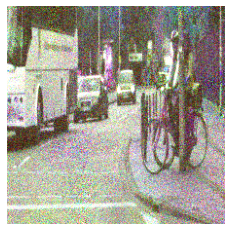

In [ ]:
img, lbl = next(iter(class_dset))
plt.imshow(img / 128 + 1); plt.axis("off"); plt.show()

## Load an ImageNet-pretrained ResNet classifier.

In [ ]:
def get_default_classifier(
    num_classes: int = 2, fixed_imagenet: bool = False,
    regularized: bool = False) -> tf.keras.Model:
  """Initializes and compiles the default ResNet50 classifier model.

  Arguments:
    num_classes: number of class labels.
    fixed_imagenet: if True, a fixed ImageNet pretrained classifier will be
    used. Otherwise, the classifier feature extractor will be initialized with
    ImageNet weights for future finetuning.
    regularized: if True, the dense layer will be regularized.
  Returns:
  tf.keras.Model classifier.
  """
  if fixed_imagenet:
    class_model = tf.keras.applications.ResNet50(include_top=True,
                                                 weights="imagenet")
  else:
    base_model = tf.keras.applications.ResNet50(include_top=False,
                                                weights="imagenet")
    base_model.trainable = True
    for layer in base_model.layers[:-15]:
      layer.trainable = False
    if regularized:
      reg = tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3)
    else:
      reg = None
    class_model = tf.keras.Sequential(
        [
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(512, activation="selu"),
            tf.keras.layers.Dense(256, activation="selu"),
            tf.keras.layers.Dense(128,
                                  kernel_regularizer=reg),
            tf.keras.layers.Dense(num_classes, activation="softmax")
        ]
    )
  return class_model


def maybe_restore_checkpoint(model: tf.keras.Model,
                             ckpt_path: Optional[str] = None) -> bool:
  """Optionally restores model from a checkpoint.

  Arguments:
    model: target model.
    ckpt_path: path to the checkpoint. If None, the checkpoint will not be
    restored.
  Returns:
    True if checkpoint is restores.
  """
  if ckpt_path is not None:
    latest = tf.train.latest_checkpoint(ckpt_path)
    if latest is not None:
      model.load_weights(latest)
      return True
  return False

In [ ]:
def write_log(log_file: Optional[str] = None, line: str = "") -> None:
  if log_file is not None:
    log_file.write(line)
    logging.info(line)
  print(line)

def train_classifier(model: tf.keras.Model, train_data: tf.data.Dataset,
                     test_data: tf.data.Dataset,
                     checkpoint_dir: Optional[str] = None,
                     lrate: float = 1e-4, num_epochs: int = 5,
                     batch_size: int = 32, log_file: Optional[Any] = None) -> None:
  """Trains the classifier on the given dataset.

  Arguments:
    model: classifier model.
    train_data: training set of samples (H, W, 3).
    test_data: test set of samples (H, W, 3).
    checkpoint_dir: path to checkpoint.
    lrate: learning rate.
    num_epochs: number of epochs.
    batch_size: batch size.
    log_file: optional log file.
  """
  # check if the dataset is not batched
  if len(next(iter(train_data))[0].shape) == 3:
    train_data = train_data.batch(batch_size, drop_remainder=True)
  if len(next(iter(test_data))[0].shape) == 3:
    test_data = test_data.batch(batch_size, drop_remainder=True)
  assert len(next(iter(train_data))[0].shape) == 4
  assert len(next(iter(test_data))[0].shape) == 4
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      lrate, decay_steps=500, decay_rate=0.96)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=["accuracy"])
  # if maybe_restore_checkpoint(model, checkpoint_dir):
  #   write_log(log_file, "Restored latest checkpoint from %s\n" % checkpoint_dir)
  callbacks = []
  if checkpoint_dir is not None:
    checkpoint_path = opj(checkpoint_dir, "cp-{epoch:04d}.ckpt")
    # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
    #                                                  save_weights_only=True,
    #                                                  save_freq="epoch")
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, save_best_only=True, save_freq='epoch')
    callbacks.append(cp_callback)
  model.fit(
      train_data,
      validation_data=test_data,
      batch_size=batch_size,
      epochs=num_epochs
  )
  res = model.evaluate(test_data)
  write_log(log_file, "Evaluation result: %s \n" % res)

In [ ]:
def prepare_splits(
    dataset: tf.data.Dataset, split: float = 0.75,
    batch_size: int = 32) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
  """Shuffles, splits and batches the dataset into train and test splits."""
  sh_dset = dataset.prefetch(tf.data.AUTOTUNE).shuffle(buffer_size=2000)
  num_data = tf.data.experimental.cardinality(sh_dset)
  num_train = tf.cast(tf.math.ceil(tf.cast(num_data, tf.float32) * split),
                      tf.int64)
  num_test = num_data - num_train
  train_dset = sh_dset.take(num_train).batch(batch_size, drop_remainder=True)
  test_dset = sh_dset.skip(num_train).take(num_test).batch(batch_size,
                                                           drop_remainder=True)
  return train_dset, test_dset

## Load the localization dataset
Now that we've trained a classifier on our classification data, we can use it to compute the RISE CAM predictions.

In [ ]:
def get_localization_dataset(
    datapath: str, 
    image_size: Optional[List[int]] = None) -> tf.data.Dataset:
  """Returns the localization dataset of tuples (image, segmentation_mask).

  Arguments:
    sstable_path: path to the sstables containing the presence and absence data.
    Must contain file `labeled.sst` or sharded `labeled.sst`.
    num_shards: number of shards.
    image_size: output image size (H, W). Default size is (224, 224).
  Returns:
    tf.data.Dataset of tuples (image, segmentation_mask).
  """
  def process_sample_for_localization(x):
    """Process a tf.Example to return image and class label."""
    img = tf.cast(x["image"], tf.float32)
    img = tf.image.resize(img, image_size)
    # img = img / 255.
    segm = x["segm"]
    segm = tf.image.resize(segm, image_size, "nearest")
    img = resnet.preprocess_input(img)
    idx = x["metadata"]["id"]
    return idx, img, segm

  if image_size is None:
    image_size = [224, 224]
  assert len(image_size) == 2

  pres_dset = read_dataset(opj(datapath, "unlabeled.tfrecord")
  return pres_dset.map(process_sample_for_localization)


## Create a RISE explainer

In [ ]:
class RiseExplainer():
  """RISE explainer for explanation of classifier prediction.

  Attributes:
    classifier: tf.keras.Model classifier model.
    input_size: input image shape (H, W). Default value is [224, 224].
    num_classes: number of classes in the dataset.
    num_masks: number of masks.
    cell_size: size of the grid cells. All dimensions of image size should be
    divisible by cell_size.
    prob: probability of a grid cell being masked.
    seed: random seed.
    random_masks: random binary mask array of shape (N, H, W) or (N, H, W, 1).
    chunk_size: size of the masked batch. Number of masks must be divisible by
    chunk size.
  """

  def __init__(self, classifier: tf.keras.Model,
               num_classes: int = 2, num_masks: int = 1000,
               input_size: Optional[List[int]] = None,
               cell_size: int = 8, rand_prob: float = 0.5,
               seed: Optional[int] = None,
               random_masks: Optional[np.ndarray] = None,
               chunk_size: int = 100):
    if num_masks % chunk_size > 0:
      raise ValueError("Number of masks must be divisible by chunk size;"
                       " got %i and %i" % (num_masks, chunk_size))
    self.num_classes = num_classes
    self.classifier = classifier
    self.input_size = [224, 224] if input_size is None else input_size
    self.num_masks = num_masks
    self.cell_size = cell_size
    self.prob = rand_prob
    self.seed = seed
    self.chunk_size = chunk_size
    self._rng = np.random.default_rng(self.seed).random
    if random_masks is None:
      self.generate_masks()
    else:
      if random_masks.shape == (self.num_masks, *self.input_size):
        random_masks = random_masks[..., None]
      if random_masks.shape != (self.num_masks, *self.input_size, 1):
        raise ValueError("Invalid shape of random masks. Should be %s or %s, "
                         "got %s" % ((self.num_masks, *self.input_size),
                                     (self.num_masks, *self.input_size, 1),
                                     random_masks.shape))
      self.random_masks = random_masks
    self._flat_masks = self.random_masks.reshape([self.num_masks, -1])

  @tf.function
  def predict_fn(self, img):
    return self.classifier(img, training=False)

  def generate_masks(self) -> None:
    """Generates random binary masks."""
    if len(self.input_size) != 2:
      raise ValueError("Input shape must of length 2 (H, W). Got %s" %
                       self.input_size)
    if not all([self.cell_size < x for x in self.input_size]):
      raise ValueError("Cell size should be smaller than input size. "
                       "Got %d and %s." % (self.cell_size, self.input_size))
    if not all([x % self.cell_size == 0 for x in self.input_size]):
      raise ValueError("Input size must be divisible by cell size along all"
                       " dimensions, got %d and %s." % (self.cell_size,
                                                        self.input_size))
    if not 0 < self.prob <= 1:
      raise ValueError("Mask probability must be within (0, 1], got %f." %
                       self.prob)
    if self.num_masks < 1:
      raise ValueError("Number of masks must be positive, got %d." %
                       self.num_masks)

    grid_size = (np.array(self.input_size) / self.cell_size).astype(np.int32)
    grid_size = (self.num_masks, *grid_size, 1)
    rand_grid = (self._rng(grid_size) < self.prob).astype("float32")
    out_masks = np.zeros((self.num_masks, *self.input_size, 1),
                         dtype=np.float32)
    for idx in tqdm.tqdm(range(self.num_masks), desc="Generating masks"):
      out_masks[idx] = tf.image.resize(rand_grid[idx],
                                       self.input_size, "bilinear")
    self.random_masks = out_masks

  def explain(self, image: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    """Explains the classifier prediction for a given example and label.

    Arguments:
      image: input image of shape (H, W, 3) or (1, H, W, 3).
    Returns:
      Classifier prediction and a RISE CAM for the given image (C, H, W).
    """
    if len(image.shape) == 3:
      image = image[None, ...]
    if image.shape[:3] != (1, *self.input_size):
      raise ValueError("Wrong input image size. Expected %s, got %s." %
                       ((1, *self.input_size), image.shape[:3]))
    masked_images = image * tf.repeat(self.random_masks,
                                      3, axis=-1)  # (N, H, W, 3)
    masked_pred_chunks = []
    # splitting N masked images into chunks to fit into memory
    for chunk in tf.split(masked_images, self.num_masks // self.chunk_size, 0):
      masked_pred_chunks.append(
          self.predict_fn(chunk))  # (chunk_size, C)
    masked_pred = tf.concat(masked_pred_chunks, 0)  # (N, C)
    if masked_pred.shape[-1] != self.num_classes:
      raise ValueError("Number of classes predicted by the classifier does not "
                       "match num_classes. Should be %d, got %d" %
                       (masked_pred.shape[-1], self.num_classes))
    pred = self.predict_fn(image)
    weighted_pred = tf.transpose(masked_pred) @ self._flat_masks  # (C, H * W)
    explanation = tf.reshape(weighted_pred, [self.num_classes,
                                             *self.input_size])
    explanation = explanation / (self.num_masks * self.prob)
    return pred, explanation


In [ ]:
def compute_rise_localization(
    rise_explainer: RiseExplainer, 
    loc_dataset: tf.data.Dataset, 
    save_path: str):
  """Computes RISE CAM localization for a given dataset."""

  def rescale(tensor):
    minval = tf.reduce_min(tensor)
    maxval = tf.reduce_max(tensor)
    return (tensor - minval) / (maxval - minval)

  def explain_sample(idx, img, segm):
      """Produces RISE CAMs for the given image sample."""
      explanation = explainer.explain(img)[1][1]
      sal_mask = tf.cast(rescale(explanation) * 255., tf.uint8)[..., None]
      return idx, segm, sal_mask

  def sal_data_generator(dataset):
    for idx, sample in enumerate(dataset):
      tf.compat.v1.logging.info(str(idx))
      yield explain_sample(*sample)

  out_folder = opj(save_path, "rise_predictions")
  if not gfile.Exists(out_folder):
    gfile.MakeDirs(out_folder)
  write_data(sal_data_generator(loc_dataset), out_folder)
  print("Done saving predictions to %s \n" % out_folder)


In [ ]:
class AverageHitScore(tf.keras.metrics.Metric):
  """Hit score metric for object localization.

  The foreground object location is assigned to the pixel with the maximum value
  of the saliency map. The prediction counts as a "hit" if it within the ground
  truth area of the foreground object. The metric computes the average
  percentage of hits across the predicted locations (i.e.,
  #hits/(#hits + #misses)).
  """

  def __init__(self, name="average_hit_score", **kwargs):
    super(AverageHitScore, self).__init__(name=name, **kwargs)
    self.num_hits = self.add_weight(name="hits", initializer="zeros")
    self.num_pred = self.add_weight(name="samples", initializer="zeros")

  def update_state(self, y_true, y_pred, sample_weight=None):
    if y_true.shape.ndims not in [3, 4]:
      raise ValueError("y_true should be a tensor of rank 3 or 4, got rank %r" %
                       y_true.shape.ndims)
    if y_pred.shape != y_true.shape:
      raise ValueError("y_true and y_pred should be of the same shape, got %s "
                       "and %s" % (y_pred.shape, y_true.shape))
    y_true = tf.cast(y_true, self.dtype)
    y_pred = tf.cast(y_pred, self.dtype)

    reshape_shape = [y_true.shape[0], -1] if y_pred.shape.ndims == 4 else [-1]
    max_axis = 1 if y_pred.shape.ndims == 4 else 0
    y_pred = tf.reshape(y_pred, reshape_shape)
    y_true = tf.reshape(y_true, reshape_shape)
    y_pred = tf.equal(
        y_pred, tf.reduce_max(y_pred, axis=max_axis, keepdims=True))
    y_pred = tf.cast(y_pred, tf.float32)
    hits = tf.reduce_sum(y_true * y_pred, axis=max_axis)
    misses = tf.reduce_sum((1. - y_true) * y_pred, axis=max_axis)
    if sample_weight is not None:
      sample_weight = tf.cast(sample_weight, self.dtype)
      hits = tf.multiply(hits, sample_weight)
      misses = tf.multiply(misses, sample_weight)

    hits = tf.reduce_sum(hits)
    misses = tf.reduce_sum(misses)
    self.num_hits.assign_add(hits)
    self.num_pred.assign_add(hits + misses)

  def result(self):
    if self.num_pred == 0:
      return tf.constant(0.)
    return self.num_hits / self.num_pred


def normalize(tensor):
  """Normalizes the tensor to be in [0, 1]."""
  minv = tf.reduce_min(tensor)
  maxv = tf.reduce_max(tensor)
  return (tensor - minv) / (maxv - minv + 1e-7)

In [ ]:
class BinaryIoU(tf.keras.metrics.Metric):
  """Binary intersection over union for the single-class segmentation."""

  def __init__(self, **kwargs):
    super(BinaryIoU, self).__init__(**kwargs)
    self._dtype = tf.bool
    self.total_intersec = self.add_weight(
        'total_intersection',
        shape=(),
        initializer=tf.compat.v1.zeros_initializer, dtype=tf.float32)
    self.total_union = self.add_weight(
        'total_union',
        shape=(),
        initializer=tf.compat.v1.zeros_initializer, dtype=tf.float32)
   
    
  def update_state(self, y_true, y_pred, sample_weight=None):
    """Accumulates the confusion matrix statistics.
    Args:
      y_true: The ground truth values.
      y_pred: The predicted values.
      sample_weight: Optional weighting of each example. Defaults to 1. Can be a
        `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
        be broadcastable to `y_true`.
    Returns:
      Update op.
    """
    y_true = tf.cast(y_true, self._dtype)
    y_pred = tf.cast(y_pred, self._dtype)

    # Flatten the input if its rank > 1.
    if y_pred.shape.ndims > 1:
      y_pred = tf.reshape(y_pred, [-1])

    if y_true.shape.ndims > 1:
      y_true = tf.reshape(y_true, [-1])

    I = tf.reduce_sum(tf.cast(tf.logical_and(y_true, y_pred), tf.float32))
    U = tf.reduce_sum(tf.cast(tf.logical_or(y_true, y_pred), tf.float32))
    self.total_intersec.assign_add(I)
    self.total_union.assign_add(U)
    return tf.math.divide_no_nan(I, U)
  
  def result(self):
    """Compute the mean intersection-over-union via the confusion matrix."""
    iou = tf.math.divide_no_nan(self.total_intersec, self.total_union)
    return iou



In [ ]:
def compute_rise_metrics(
  rise_explainer: rise.RiseExplainer, 
  loc_dataset: tf.data.Dataset, 
  out_file: str):
  def rescale(tensor):
    minval = tf.reduce_min(tensor)
    maxval = tf.reduce_max(tensor)
    return (tensor - minval) / (maxval - minval)

  def explain_sample(idx, img, segm):
      """Produces RISE CAMs for the given image sample."""
      explanation = rise_explainer.explain(img)[1][1]
      sal_mask = tf.cast(rescale(explanation) * 255., tf.uint8)[..., None]
      return idx, segm, sal_mask

  def sal_data_generator(dataset):
    for idx, sample in enumerate(dataset):
      tf.compat.v1.logging.info(str(idx))
      yield explain_sample(*sample)

  def update_metrics(dataset):
    for _, segm, sal_mask in dataset:
      norm_gt = normalize(tf.cast(segm, tf.float32))
      norm_pred = normalize(tf.cast(sal_mask, tf.float32))
      hit_score.update_state(norm_gt, norm_pred)
      miou_05_metric.update_state(norm_gt > 0.5, norm_pred >= 0.5)
      miou_075_metric.update_state(norm_gt > 0.5, norm_pred >= 0.75)

  miou_05_metric = BinaryIoU()
  miou_075_metric = BinaryIoU()
  hit_score = AverageHitScore()
  update_metrics(sal_data_generator(loc_dataset))
  metrics_dict = {"IoU50": miou_05_metric,
                  "IoU75": miou_075_metric,
                  "HitScore": hit_score}
  print("Total metrics:")
  with gfile.Open(out_file, "wb") as fl:
    for name, metr in metrics_dict.items():
      out_str = "%s = %.2f\n" % (name, metr.result().numpy() * 100)
      fl.write(out_str)
      print(out_str)

In [ ]:
def visualize_data(dataset: tf.data.Dataset):
  f, axarr = plt.subplots(8,8, figsize=(8*3, 8*3))
  for idx, (img, label) in enumerate(dataset.take(64)):
    grid_idx = (idx // 8, idx % 8)
    title = "present" if label > 0 else "absent"
    axarr[grid_idx].imshow(img / 128 + 1) # 
    # axarr[grid_idx].imshow(img) # 
    axarr[grid_idx].axis("off")
    axarr[grid_idx].set_title(title)
  plt.show()


def compute_rise_metrics(
  rise_explainer: rise.RiseExplainer, 
  loc_dataset: tf.data.Dataset, 
  out_file: str):
  def rescale(tensor):
    minval = tf.reduce_min(tensor)
    maxval = tf.reduce_max(tensor)
    return (tensor - minval) / (maxval - minval)

  def explain_sample(idx, img, segm):
      """Produces RISE CAMs for the given image sample."""
      explanation = rise_explainer.explain(img)[1][1]
      sal_mask = tf.cast(rescale(explanation) * 255., tf.uint8)[..., None]
      return idx, segm, sal_mask

  def sal_data_generator(dataset):
    for idx, sample in enumerate(dataset):
      tf.compat.v1.logging.info(str(idx))
      yield explain_sample(*sample)

  def update_metrics(dataset):
    for _, segm, sal_mask in dataset:
      norm_gt = normalize(tf.cast(segm, tf.float32))
      norm_pred = normalize(tf.cast(sal_mask, tf.float32))
      hit_score.update_state(norm_gt, norm_pred)
      miou_05_metric.update_state(norm_gt > 0.5, norm_pred >= 0.5)
      miou_075_metric.update_state(norm_gt > 0.5, norm_pred >= 0.75)

  miou_05_metric = BinaryIoU()
  miou_075_metric = BinaryIoU()
  hit_score = AverageHitScore()
  update_metrics(sal_data_generator(loc_dataset))
  metrics_dict = {"IoU50": miou_05_metric,
                  "IoU75": miou_075_metric,
                  "HitScore": hit_score}
  print("Total metrics:")
  with open(out_file, "wb") as fl:
    for name, metr in metrics_dict.items():
      out_str = "%s = %.2f\n" % (name, metr.result().numpy() * 100)
      fl.write(out_str)
      print(out_str)
  

def train_on_augmented_and_eval_cams(
    datapath: str, ckpt_path: str, out_file: str, 
    augment_type: str, exp_name: str, **augment_args):
  class_dset = get_classification_dataset(
    datapath, image_size=[224, 224], 
    augment_type=augment_type, **augment_args)
  visualize_data(class_dset)
  os.makedirs(out_file, exists_ok=True)
  with open(opj(out_file, "example-dataset-%s" % exp_name), 'wb') as f:
    plt.savefig(f, format='png')
  classifier = get_default_classifier(
      num_classes=2, fixed_imagenet=False, regularized=True)
  new_ckpt_path = opj(ckpt_path, "%s.ckpt" % exp_name)
  if maybe_restore_checkpoint(classifier, new_ckpt_path):
    print("Restored latest checkpoint from %s" % ckpt_path)
  else:
    print("Checkpoint not restored.")
  train_ds, test_ds = prepare_splits(class_dset, batch_size=32)
  train_classifier(
      classifier, 
      train_data=train_ds, 
      test_data=test_ds,
      checkpoint_dir=ckpt_path,
      lrate=5e-4, 
      num_epochs=20,
      batch_size=32)
  loc_dset = get_localization_dataset(
          datapath, image_size=[224, 224], sigma=sigma)
  explainer = rise.RiseExplainer(
    classifier, num_classes=2, num_masks=3000, rand_prob=0.4,
    cell_size=32, input_size=[224, 224], seed=123)
  miou_05_metric = BinaryIoU()
  miou_075_metric = BinaryIoU()
  hit_score = AverageHitScore()
  # visualize the first saliency maps
  f, axarr = plt.subplots(3,8, figsize=(8*5, 3*5))
  for idx, (_, img, mask) in enumerate(loc_dset.take(8)):
    _, sal_mask = explainer.explain(img)
    axarr[0, idx].imshow(img / 128 + 1)  
    axarr[0, idx].axis("off")
    axarr[0, idx].set_title("Image")
    axarr[1, idx].imshow(mask)  
    axarr[1, idx].axis("off")
    axarr[1, idx].set_title("GT mask")
    axarr[2, idx].imshow(img) 

    norm_gt = normalize(tf.cast(mask, tf.float32))
    norm_pred = normalize(tf.cast(sal_mask[1][..., None], tf.float32))
    axarr[2, idx].imshow(norm_pred, cmap='jet', alpha=0.5)
    hit_score.update_state(norm_gt, norm_pred)
    miou50 = 100 * miou_05_metric.update_state(norm_gt > 0.5, norm_pred >= 0.5)
    miou75 = 100 * miou_075_metric.update_state(norm_gt > 0.5, norm_pred >= 0.75)
    hitscore = np.round(100 * hit_score.result().numpy())
    axarr[2, idx].axis("off")
    axarr[2, idx].set_title(
        "mIoU50 %i, mIoU75 %i, HS %i" % (miou50, miou75, hitscore))
    for metric in [miou_05_metric, miou_075_metric, hit_score]:
      metric.reset_state()
  with open(opj(out_file, "example-salmasks-%s.png" % exp_name), 'wb') as f:
    plt.savefig(f, format='png')
  plt.show()
  # compute the metrics
  new_out_file = opj(out_file, "metrics-%s.txt" % exp_name)
  compute_rise_metrics(explainer, loc_dset, new_out_file)